<a href="https://colab.research.google.com/github/gileshall/citus/blob/main/notebooks/GATK_Paper_Dive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this notebook where we'll explore a dataset of publications related to the Genome Analysis Toolkit (GATK). Our goal is to analyze publication trends over time and visualize insights from various categorical aspects of the data. We'll begin by importing the necessary libraries for data manipulation and visualization.

In [9]:
import requests
import json
import numpy as np
import pandas as pd
from pprint import pprint
from collections import defaultdict as dd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_theme()

# Loading and Preprocessing the Data

We start by loading the dataset directly from an online JSON file into a pandas DataFrame. The dataset contains information about GATK-related publications, including their publication dates and several categorical attributes.

## Key steps in this section:

- Load the dataset from a remote JSON source.
- Clean the data by:
  - Removing records with missing publication years or months.
  - Filtering out publications before 2015.
- Create a `publication_month_year` column to facilitate time series analysis by combining the publication year and month into a single datetime column.

In [10]:
dataset_url = "https://drive.usercontent.google.com/download?id=1HJkdH-mz0As_BIf1JIBSEhMmKBZ5a-h-"
gatk_releases_url = "https://drive.usercontent.google.com/download?id=1qRZUWRLAy-mOBmI1G7daUxZnNFcqZ6OC"

df = pd.read_json(dataset_url)

# clean up any bad dates
df = df[df.publication_year.notna()]
df = df[df.publication_month > 0]
df = df[df.publication_year > 2014]

# create a real datetime column for time series
df['publication_month_year'] = pd.to_datetime(
    df['publication_year'].astype(int).astype(str) + '-' + \
    df['publication_month'].astype(int).astype(str) + '-01'
)

releases_df = pd.read_json(gatk_releases_url)

# Visualizing Publication Trends

### In this section, we'll define helper functions to process the data and generate insightful visualizations:

1. **`explode_and_flag`**:
   - Processes categorical columns containing lists by:
     - Exploding the lists to count individual item occurrences.
     - Identifying items that occur above a certain threshold.
     - Creating boolean flags for high-occurrence items and an 'Other' category for the rest.

2. **`graph_publish_timeseries`**:
   - Generates cumulative time series plots for specified categorical columns.
   - Adds vertical dashed lines to indicate the release dates of different software versions (e.g., GATK versions). These lines are annotated with version numbers to correlate publication trends with software updates.
   - Allows filtering and visualization of categories using various flags and thresholds.

### Using these functions, we produce the following graphs:

1. **Cumulative Publications by Biological Application Area**:
   - Displays the growth of GATK publications across various biological application areas from 2015 to 2024.
   - Includes vertical lines and annotations for GATK software releases, offering insights into how major updates may influence publication trends.

2. **Cumulative Publications by Methodological Details**:
   - Focuses on specific methodological aspects such as 'Long Reads' and 'Mitochondrial' studies.
   - Highlights trends over time while correlating them with GATK software updates.

3. **Cumulative Publications by Species Used (Excluding Human and Other)**:
   - Highlights trends in publication growth for species other than *Homo sapiens*.
   - Excludes low-occurrence species and the 'Other' category, focusing on the most significant contributors.
   - Vertical release lines are included for reference.

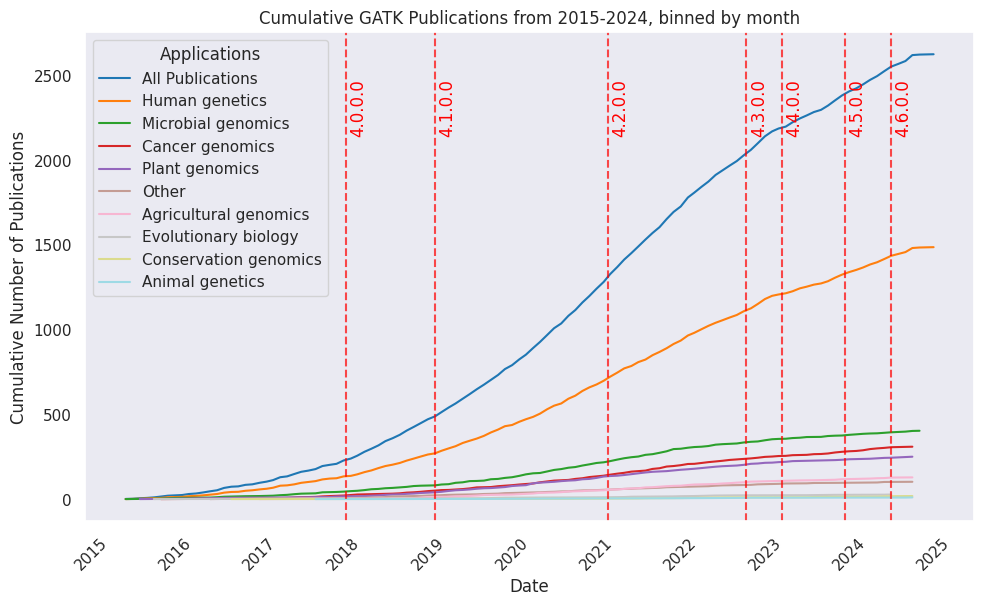

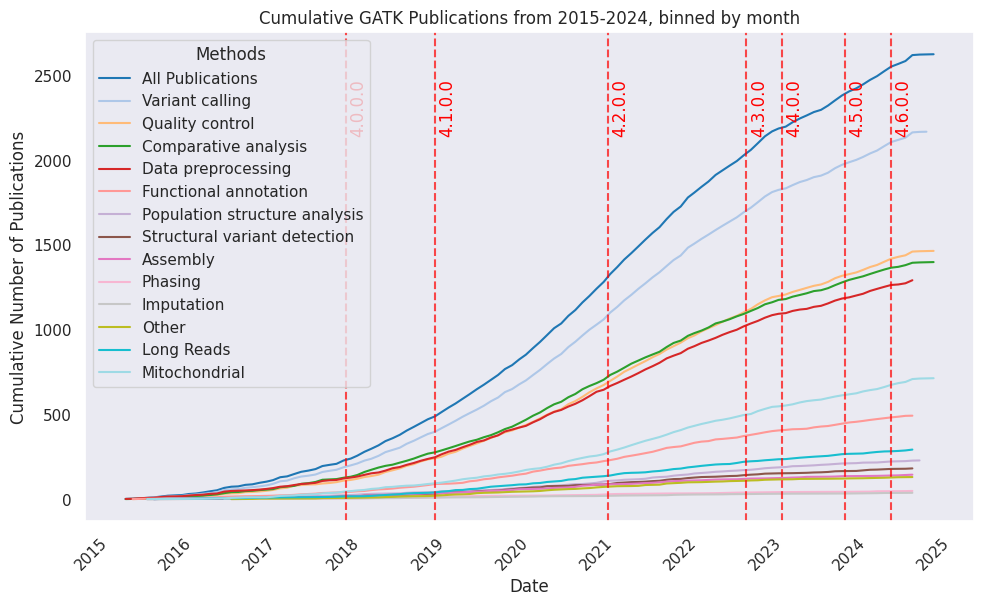

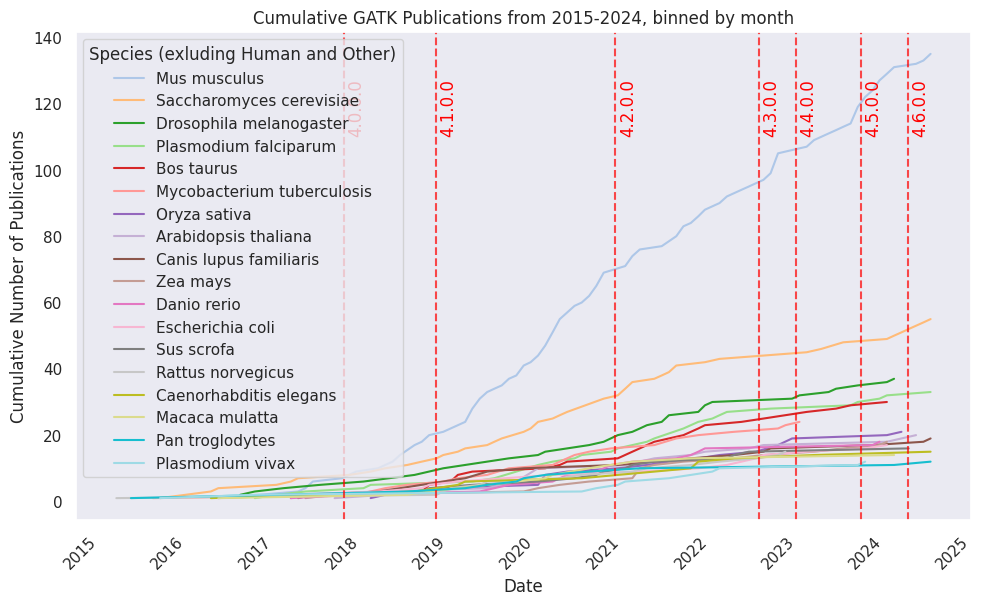

In [11]:
def explode_and_flag(df, col, threshold=10, prefix='', suffix='flag', inplace=False):
    # Explode the items column to count individual item occurrences
    if not inplace:
        df = df.copy()
    exploded_df = df.explode(col)
    item_counts = exploded_df[col].value_counts()

    # Identify items that occur more than the threshold number of times
    high_occurrence_items = item_counts[item_counts > threshold].index.tolist()
    low_occurrence_items = item_counts[item_counts <= threshold].index.tolist()

    # Create new columns for high occurrence items and flag them in the original DataFrame
    flag_col_map = {}
    for item in high_occurrence_items:
        new_col_name = f'{"_".join(item.lower().split(" "))}'
        if prefix:
            new_col_name = f'{prefix}_{new_col_name}'
        if suffix:
            new_col_name = f'{new_col_name}_{suffix}'
        flag_col_map[item] = new_col_name
        df[new_col_name] = df[col].apply(lambda x: item in x if isinstance(x, list) else False)

    # Create a column for "other" items (those that do not meet the threshold)
    other_col_name = f'{prefix}_other_{suffix}' if prefix else f'other_{suffix}'
    flag_col_map['Other'] = other_col_name
    df[other_col_name] = df[col].apply(
        lambda x: any(item in x for item in low_occurrence_items) if isinstance(x, list) else False
    )

    return (df, flag_col_map)

def graph_publish_timeseries(df, col, flags=None, threshold=10, filter_na=True, graph_all=True, graph_other=True, skip=tuple()):
    ddf = df.copy()
    flags = (flags or dict()).copy()
    (ddf, _flags) = explode_and_flag(ddf, col=col, prefix='graph_pub', threshold=threshold)
    _flags.update(flags)

    monthly_counts_all = ddf.groupby(ddf['publication_month_year'].dt.to_period("M")).size()
    cumulative_counts_all = monthly_counts_all.cumsum()
    # Convert period index to timestamp
    cumulative_counts_all.index = cumulative_counts_all.index.to_timestamp()

    color_map = plt.colormaps['tab20'].resampled(len(_flags) + 1)

    (fig, ax) = plt.subplots(figsize=(10, 6))
    if graph_all:
        plt.plot(cumulative_counts_all.index, cumulative_counts_all.values, linestyle='-', label='All Publications', color=color_map(0))

    # Loop through each flag and plot the cumulative count for each concept
    for (idx, (app_label, app_col)) in enumerate(_flags.items()):
        if not graph_other:
            if app_label.lower() == 'other':
                continue
        if any([it in app_label.lower() for it in skip]):
            continue
        if filter_na and (app_label.lower() in {'not applicable', 'na', 'n/a', 'nan'}):
            continue

        # Filter rows where the concept flag is True (or 1)
        filtered_ddf = ddf[ddf[app_col] == 1]

        # Group by month and year, and count occurrences for the concept
        monthly_counts_concept = filtered_ddf.groupby(filtered_ddf['publication_month_year'].dt.to_period("M")).size()
        cumulative_counts_concept = monthly_counts_concept.cumsum()
        cumulative_counts_concept.index = cumulative_counts_concept.index.to_timestamp()

        # Plot cumulative counts for this concept
        plt.plot(cumulative_counts_concept.index, cumulative_counts_concept.values, linestyle='-', label=app_label, color=color_map(idx + 1))

    for (idx, row) in releases_df.iterrows():
        date = row['published_at']
        version = row['tag_name']
        vals = version.split('.')
        if len(vals) >= 2 and vals[2] != '0':
            continue
        ax.axvline(date, color='red', linestyle='--', alpha=0.7)
        # add a few days so the text is not setting on the line
        ax.text(date + timedelta(days=15), ax.get_ylim()[1] * 0.9, version, rotation=90, va='top', color='red')


    plt.xlabel('Date')
    plt.ylabel('Cumulative Number of Publications')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    return fig

fig = graph_publish_timeseries(df, col='biological_application_area')
plt.title('Cumulative GATK Publications from 2015-2024, binned by month')
plt.legend(title='Applications')
plt.show()
print()

meth_flags = {
    'Long Reads': 'long_read_technology_related',
    'Mitochondrial': 'mitochondria_related',
}

fig = graph_publish_timeseries(df, col='methodological_details', flags=meth_flags)
plt.title('Cumulative GATK Publications from 2015-2024, binned by month')
plt.legend(title='Methods')
plt.show()
print()

fig = graph_publish_timeseries(df, col='species_used', threshold=11, graph_all=False, skip=('homo sapiens',), graph_other=False)
plt.title('Cumulative GATK Publications from 2015-2024, binned by month')
plt.legend(title='Species (exluding Human and Other)')
plt.show()